# Carregar as bibliotecas

In [ ]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure, measure
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
from torchvision import datasets

## Carregar base MNIST para classificar usando Rede Neural

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

In [ ]:
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()


## Classificando usanda uma RNA

In [ ]:
# Definição da rede
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=128), # Capa Fully Connected
    nn.ReLU(), # Função de ativação ReLU
    nn.Linear(in_features=128,out_features=10) # Capa Fully Connected
)
# nao é necessário uma função softmax no final devido à função Loss utilizada

### Verifica disponibilidade de GPU, se tiver, o modelo é enviado à GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


NameError: ignored

### Definição da função de perda (*Loss function*) e da função de otimização para minimização do erro

In [ ]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adagrad( model.parameters() )

## Datalaloader usada para criar batches durante o treino

In [ ]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True) 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False) 

batch de dados: torch.Size([128, 1, 28, 28])
batch de etiquetas: torch.Size([128])


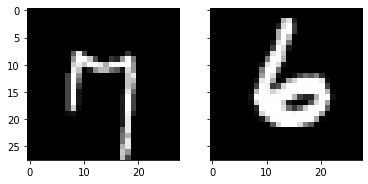

In [ ]:
# verificação do funcionamento do dataloader
for x, y in train_loader:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
#    ax2.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
    ax1.imshow(x[0].numpy()[-1,:,:], cmap = 'gray')
    ax2.imshow(x[1].numpy()[-1,:,:], cmap = 'gray')
    break


## Treino

In [ ]:
def fit(model, criterion, optimizer, train_loader, test_loader, n_epochs=10):
  # salva o Loss do treino e o teste em cada época
  train_losses = np.zeros(n_epochs)
  test_losses = np.zeros(n_epochs)

  # itera por cada época
  for it in range(n_epochs):

      train_loss = []
      # carregar batch de dados e de etiquetas do treino
      for inputs, targets in train_loader:
          # mover os dados para o GPU ou CPU
          inputs, targets = inputs.to(device), targets.to(device)

          # modificar a dimensão de batch X height X width X channel   ->    batch x (height*width*channel)
          #                          128 x 28 x 28 x 1                 ->     128 x (28*28*1)
          inputs = inputs.view(-1, 784)
          # zerar os gradientes
          optimizer.zero_grad()

          # forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          # backward pass e optimização para minimizar o erro
          loss.backward()
          optimizer.step()

          # salva o erro do treino em cada batch
          train_loss.append( loss.item() )

      # calcula a média de erros de todos os batches para calcular o erro do treino por época
      train_loss = np.mean(train_loss)

      test_loss = []
      # carregar batch de dados e de etiquetas da validação
      for inputs, targets in test_loader:
          # mover os dados para o GPU
          inputs, targets = inputs.to(device), targets.to(device)

          # modificar a dimensão 
          inputs = inputs.view(-1, 784)

          # forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          
          # não é incluido o backward pass e a optimização porque avalia a aprendizagem

          # salva o erro do treino em cada batch
          test_loss.append(loss.item())

      # calcula a média de erros de todos os batches para calcular o erro da validação por época
      test_loss = np.mean(test_loss)

      # salvar losses de treino e validação nos vetores
      train_losses[it] = train_loss
      test_losses[it] = test_loss

      
      print(f'Epoch {it+1}/{n_epochs} Train Loss: {train_loss.item():.4f} Test Loss: {test_loss.item()}')
  return train_loss, test_loss


In [ ]:
train_losses, test_losses = fit(model, criterion, optimizer, train_loader, test_loader, n_epochs = 10)



Epoch 1/10 Train Loss: 0.2188 Test Loss: 0.19427382000545157
Epoch 2/10 Train Loss: 0.1861 Test Loss: 0.1737366714514792
Epoch 3/10 Train Loss: 0.1656 Test Loss: 0.16135701158119342
Epoch 4/10 Train Loss: 0.1513 Test Loss: 0.14873595708462445
Epoch 5/10 Train Loss: 0.1401 Test Loss: 0.14008923306401017
Epoch 6/10 Train Loss: 0.1310 Test Loss: 0.1346347292537412
Epoch 7/10 Train Loss: 0.1235 Test Loss: 0.12862618247789767
Epoch 8/10 Train Loss: 0.1171 Test Loss: 0.12469328546165666
Epoch 9/10 Train Loss: 0.1116 Test Loss: 0.12046984928848717
Epoch 10/10 Train Loss: 0.1070 Test Loss: 0.11748689351178988


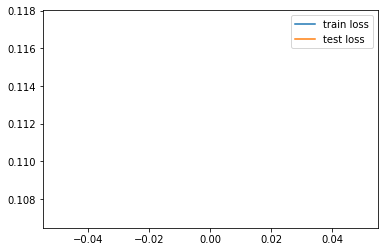

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

## Gerando todas as etiquetas do conjunto de teste

In [ ]:
def predict_module(model, data_loader):
  model.eval()
  predicted = np.empty((0), int)
  true_labels = np.empty((0), int)
  for inputs, targets in data_loader:
      # mover os dados para o GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # modificar a dimensão 
      inputs = inputs.view(-1, 784)

      # 
      outputs = model(inputs)

      # obter a predição
      _, predictions = torch.max(outputs, 1)

      predicted = np.append(predicted, predictions)
      true_labels = np.append(true_labels, targets)

  return predicted, true_labels

In [ ]:
predicted, true_labels = predict_module(model, test_loader)

## Matriz de confusão

In [ ]:
def matriz_confusao(true_labels, predicted):
    m = metrics.confusion_matrix(true_labels, predicted) 
    tot = np.sum(m, axis=1, keepdims=True) 

    m_porc = m/tot
    m_porc_str = np.array2string(m_porc, formatter={'float_kind':lambda x: "%.2f" % x})
    print( m_porc_str )

    np.set_printoptions(precision=2, suppress = True)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[0,1,2,3,4,5,6,7,8,9])
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

[[0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.00 0.01 0.00]
 [0.00 0.00 0.00 0.97 0.00 0.01 0.00 0.01 0.00 0.01]
 [0.00 0.00 0.00 0.00 0.97 0.00 0.01 0.00 0.00 0.02]
 [0.00 0.00 0.00 0.02 0.00 0.96 0.01 0.00 0.01 0.00]
 [0.01 0.00 0.00 0.00 0.01 0.01 0.97 0.00 0.00 0.00]
 [0.00 0.01 0.01 0.01 0.00 0.00 0.00 0.95 0.00 0.02]
 [0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.00 0.95 0.01]
 [0.00 0.01 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.95]]


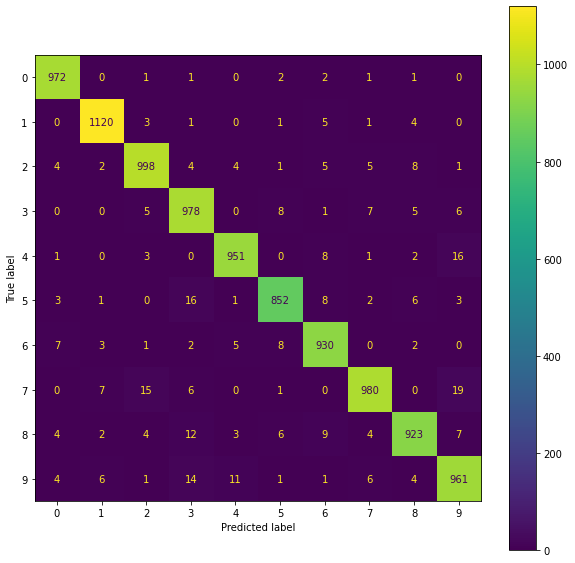

In [ ]:
matriz_confusao(true_labels, predicted) 



# Questão 1

<p> Modifique o número de camadas da rede </p>

In [ ]:
# Definição da rede
model_new = nn.Sequential(
      nn.Linear(in_features=784, out_features=128), # Capa Fully Connected
      nn.ReLU(), # Função de ativação ReLU
      nn.Linear(in_features=128,out_features=64), # Capa Fully Connected
      nn.ReLU(), # Função de ativação ReLU
      nn.Linear(in_features=64,out_features=10) # Capa Fully Connected
)
# nao é necessário uma função softmax no final devido à função Loss utilizada

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_new.to(device)

cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# Loss para varias classes
criterion_new = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adagrad( model_new.parameters() )

In [ ]:
train_losses, test_losses = fit(model_new, criterion_new, optimizer, train_loader, test_loader, n_epochs = 10)

Epoch 1/10 Train Loss: 0.3321 Test Loss: 0.1977879955445098
Epoch 2/10 Train Loss: 0.1817 Test Loss: 0.16022293376913177
Epoch 3/10 Train Loss: 0.1490 Test Loss: 0.1387587652211608
Epoch 4/10 Train Loss: 0.1289 Test Loss: 0.1255691307950529
Epoch 5/10 Train Loss: 0.1141 Test Loss: 0.11767931557790953
Epoch 6/10 Train Loss: 0.1036 Test Loss: 0.10809361681348019
Epoch 7/10 Train Loss: 0.0951 Test Loss: 0.10371776772780886
Epoch 8/10 Train Loss: 0.0881 Test Loss: 0.09909709332852706
Epoch 9/10 Train Loss: 0.0827 Test Loss: 0.09558062469793036
Epoch 10/10 Train Loss: 0.0774 Test Loss: 0.09143010510243711


[[0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.01 0.01 0.00]
 [0.00 0.00 0.01 0.97 0.00 0.00 0.00 0.01 0.01 0.00]
 [0.00 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.02]
 [0.00 0.00 0.00 0.01 0.00 0.97 0.01 0.00 0.01 0.00]
 [0.01 0.00 0.00 0.00 0.01 0.00 0.98 0.00 0.00 0.00]
 [0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.97 0.00 0.01]
 [0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.96 0.00]
 [0.00 0.01 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.95]]


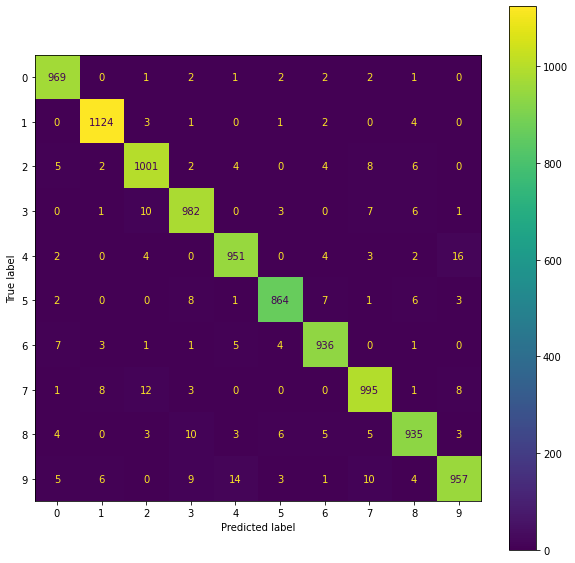

In [ ]:
predicted, true_labels = predict_module(model_new, test_loader)
matriz_confusao(true_labels, predicted) 